Liquidity Risk

유동성 위험(Liquidity Risk)란 자산을 시장에서 신속하게 원하는 가격으로 매각하거나 현금화할 수 없는 위험

## 1. Bid-Ask Spread

In [3]:
# bid-ask spread 계산 예시
bid = 10000
ask = 10100

absolute_spread = ask - bid
relative_spread = (ask - bid) / ((ask + bid) / 2) * 100

print("절대 스프레드:", absolute_spread, "원")
print("상대 스프레드: {:.3f}%".format(relative_spread))


절대 스프레드: 100 원
상대 스프레드: 0.995%


### 1-1 삼성전자: 최근 1년 일별 bid-ask spread 계산 및 시각화

In [4]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
df = stock.get_market_ohlcv_by_date(
start.strftime('%Y%m%d'),
end.strftime('%Y%m%d'),
"005930", # 삼성전자 티커
"d"
)

In [10]:
print("📌 데이터 컬럼:", df.columns)

📌 데이터 컬럼: Index(['시가', '고가', '저가', '종가', '거래량', '등락률'], dtype='object')


### 1-2 Bid-Ask Spread 계산, 평균 Bid-Ask Spread 출력

In [15]:
# pykrx는 Bid/Ask 가격을 제공하지 않으므로, 다음과 같은 근사 방법 사용:
# High: Ask Price (매도호가), Low: Bid Price (매수호가)로 가정
# df['bid_ask_spread'] = (df['고가'] - df['저가']) / ((df['고가'] + df['저가']) / 2) * 100

In [16]:
df['bid_ask_spread'] = (df['고가'] - df['저가']) / ((df['고가'] + df['저가']) / 2) * 100

# 평균 Bid-Ask Spread 출력
mean_spread = df['bid_ask_spread'].mean()
print(f"📊 삼성전자 평균 Bid-Ask Spread (최근 1년): {mean_spread:.4f}%")

📊 삼성전자 평균 Bid-Ask Spread (최근 1년): 2.3202%


### 1-3 시각화

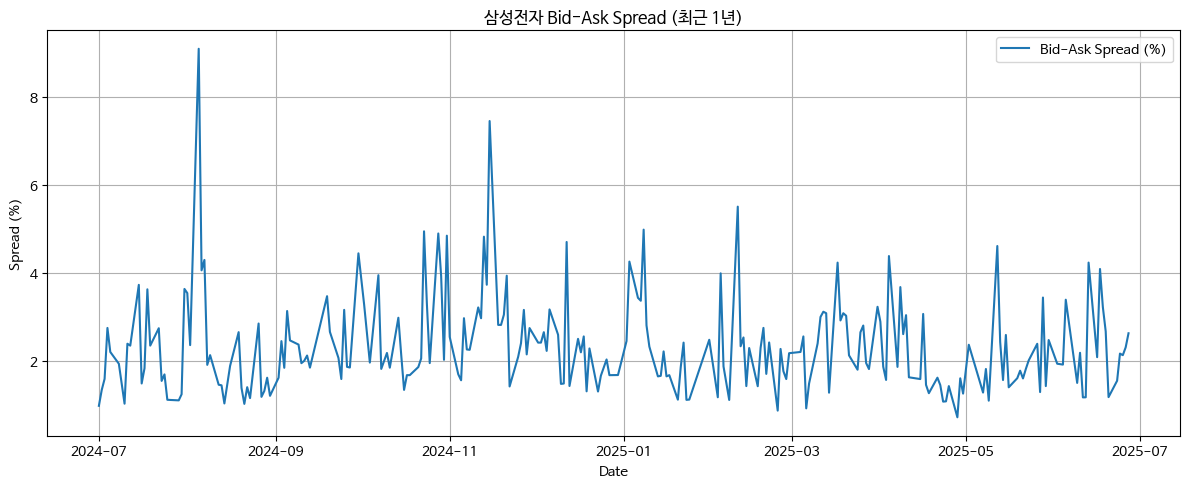

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['bid_ask_spread'], label='Bid-Ask Spread (%)')
plt.title("삼성전자 Bid-Ask Spread (최근 1년)")
plt.ylabel("Spread (%)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2.  Amihud 비유동성 지표

In [2]:
# 파이썬으로 Amihud Illiquidity 지표 계산
import pandas as pd

# 예시 데이터프레임
df = pd.DataFrame({
    'return': [0.01, -0.02, 0.015, -0.005],
    'volume': [1000000, 800000, 1200000, 900000]
})

# Amihud 비유동성 계산
df['amihud'] = df['return'].abs() / df['volume']
amihud_avg = df['amihud'].mean()

print("Amihud Illiquidity 평균:", amihud_avg)


Amihud Illiquidity 평균: 1.3263888888888888e-08


In [ ]:
# "수익률 1 단위 변화가 얼마나 적은 거래량에도 민감하게 발생하는지"를 나타냅니다.
# 숫자가 작을수록 유동성이 높고 (거래량이 많아도 가격 변동이 작음), 숫자가 클수록 유동성이 낮습니다.

### 2-2 Amihud Illiquidity Ratio  pykrx 삼성전자 

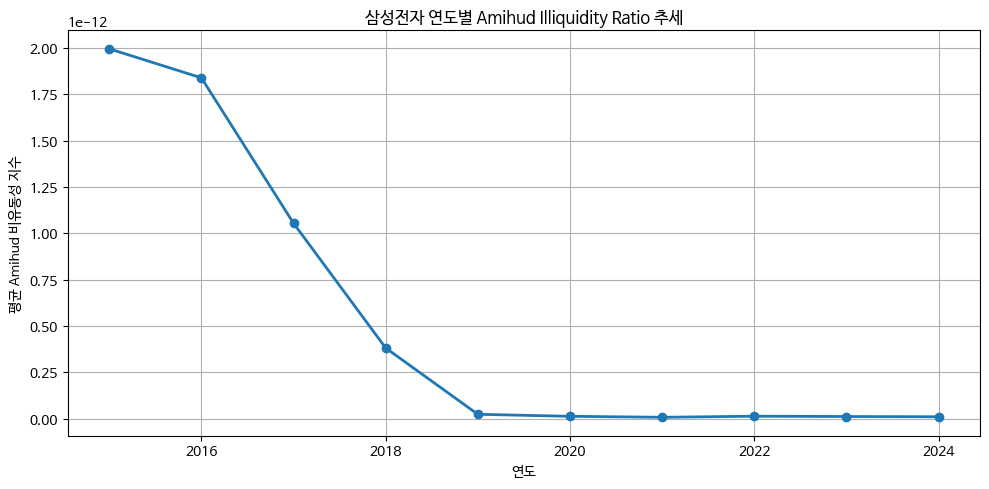

In [20]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt

# 1. 대상 종목 (삼성전자)
ticker = "005930"

# 2. 분석 연도 범위 설정 (예: 2015~2024)
years = list(range(2015, 2025))
amihud_by_year = {}

for year in years:
    start = f"{year}0101"
    end = f"{year}1231"

    # 3. 일별 시세 데이터 수집
    df = stock.get_market_ohlcv_by_date(start, end, ticker, "d")

    if df.empty:
        print(f"{year} 데이터 없음")
        continue

    # 4. 수익률 및 거래대금 계산
    df['ret'] = df['종가'].pct_change()
    df = df.dropna()

    # 거래대금 = 종가 * 거래량 (원 단위)
    df['amount'] = df['종가'] * df['거래량']

    # 5. Amihud 지수 계산
    df['amihud'] = df['ret'].abs() / df['amount']

    # 6. 해당 연도 평균 Amihud 저장
    amihud_by_year[year] = df['amihud'].mean()

# 7. 결과를 데이터프레임으로 변환
amihud_df = pd.DataFrame.from_dict(amihud_by_year, orient='index', columns=['amihud'])
amihud_df.index.name = "Year"
amihud_df.reset_index(inplace=True)

# 8. 시각화
plt.figure(figsize=(10, 5))
plt.plot(amihud_df['Year'], amihud_df['amihud'], marker='o', linewidth=2)
plt.title("삼성전자 연도별 Amihud Illiquidity Ratio 추세")
plt.xlabel("연도")
plt.ylabel("평균 Amihud 비유동성 지수")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2-4 삼성전자(005930)와 SK하이닉스(000660)의 연도별 Amihud Illiquidity Ratio 평균

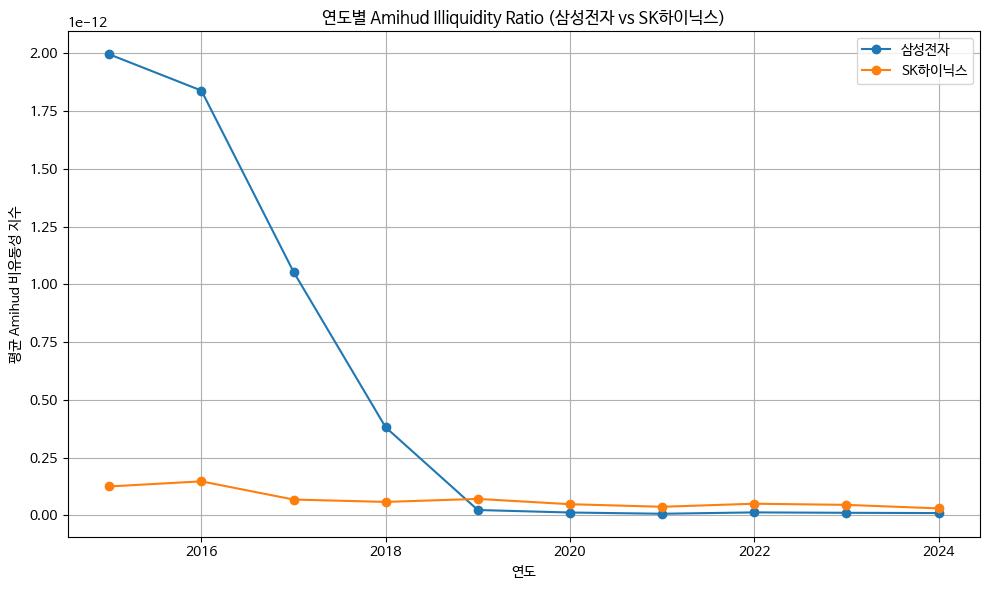

In [21]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt

# 1. 비교 대상 종목 (이름: 티커)
tickers = {
    '삼성전자': '005930',
    'SK하이닉스': '000660'
}

# 2. 연도 범위 설정
years = list(range(2015, 2025))
results = {}

# 3. 각 종목별 연도별 Amihud 계산
for name, code in tickers.items():
    amihud_by_year = {}
    for year in years:
        start = f"{year}0101"
        end = f"{year}1231"
        
        df = stock.get_market_ohlcv_by_date(start, end, code, "d")
        if df.empty:
            print(f"{name} - {year} 데이터 없음")
            continue
        
        df['ret'] = df['종가'].pct_change()
        df = df.dropna()
        df['amount'] = df['종가'] * df['거래량']
        df['amihud'] = df['ret'].abs() / df['amount']
        amihud_by_year[year] = df['amihud'].mean()
    
    # 종목별 결과 저장
    results[name] = amihud_by_year

# 4. 데이터프레임 변환
df_amihud = pd.DataFrame(results)
df_amihud.index.name = 'Year'
df_amihud = df_amihud.reset_index()

# 5. 시각화
plt.figure(figsize=(10, 6))
for name in tickers.keys():
    plt.plot(df_amihud['Year'], df_amihud[name], marker='o', label=name)

plt.title("연도별 Amihud Illiquidity Ratio (삼성전자 vs SK하이닉스)")
plt.xlabel("연도")
plt.ylabel("평균 Amihud 비유동성 지수")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 삼성전자 vs SK하이닉스)의 연도별 Amihud Illiquidity Ratio 추세 그래프를 로그스케일(log-scale)로 시각화

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

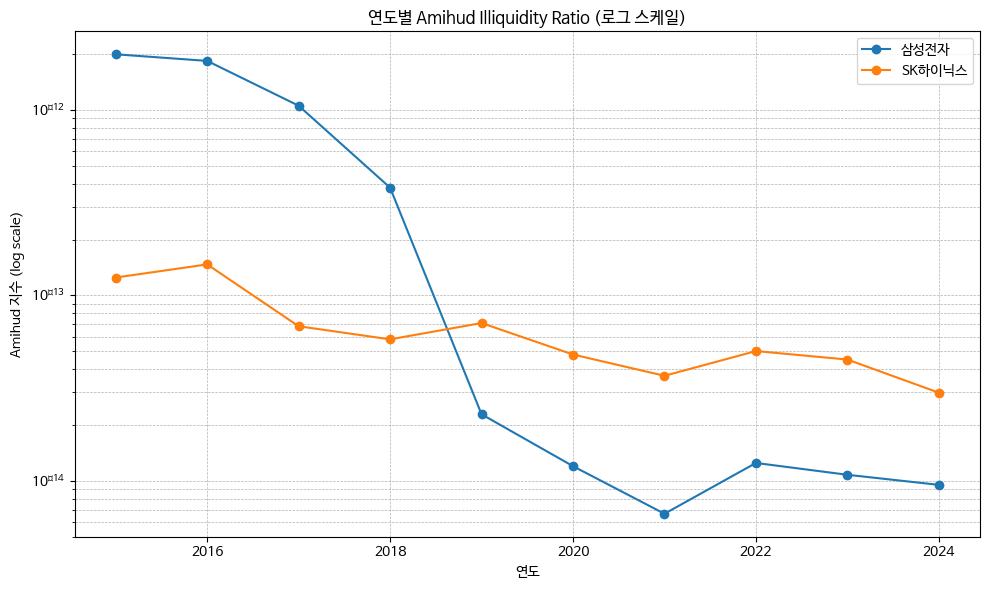

In [22]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt

# 1. 종목 설정
tickers = {
    '삼성전자': '005930',
    'SK하이닉스': '000660'
}

# 2. 연도 설정
years = list(range(2015, 2025))
results = {}

# 3. 각 종목에 대해 연도별 Amihud 계산
for name, code in tickers.items():
    amihud_by_year = {}
    for year in years:
        start = f"{year}0101"
        end = f"{year}1231"

        df = stock.get_market_ohlcv_by_date(start, end, code, "d")
        if df.empty:
            print(f"{name} - {year} 데이터 없음")
            continue

        df['ret'] = df['종가'].pct_change()
        df = df.dropna()
        df['amount'] = df['종가'] * df['거래량']
        df['amihud'] = df['ret'].abs() / df['amount']
        amihud_by_year[year] = df['amihud'].mean()
    
    results[name] = amihud_by_year

# 4. 데이터프레임 변환
df_amihud = pd.DataFrame(results)
df_amihud.index.name = 'Year'
df_amihud = df_amihud.reset_index()

# 5. 로그 스케일 그래프 시각화
plt.figure(figsize=(10, 6))
for name in tickers.keys():
    plt.plot(df_amihud['Year'], df_amihud[name], marker='o', label=name)

plt.yscale('log')  # 로그 스케일 적용
plt.title("연도별 Amihud Illiquidity Ratio (로그 스케일)")
plt.xlabel("연도")
plt.ylabel("Amihud 지수 (log scale)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 3. Roll's Spread Estimate

시장의 유동성(특히 비가시적인 거래 비용)을 추정하는 대표적인 간접적 유동성 지표

In [24]:
import numpy as np
import pandas as pd

# 1. 예시 종가 시계열 (자유롭게 변경 가능)
prices = pd.Series([100, 100.5, 100.0, 100.4, 100.1, 100.3])

# 2. 수익률 (종가 차이)
returns = prices.diff().dropna()

# 3. 시차 1 자기공분산 계산
cov = returns[:-1].cov(returns[1:])

# 4. Roll 스프레드 계산
if cov < 0:
    roll_spread = 2 * np.sqrt(-cov)
    print(f"Roll Spread Estimate: {roll_spread:.4f}")
else:
    print("양(+)의 공분산 → Roll Spread 추정 불가")


양(+)의 공분산 → Roll Spread 추정 불가


### 3-2 . 삼성전자(005930)와 SK하이닉스(000660) : Roll’s Spread Estimate

In [25]:
from pykrx import stock
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. 종목 목록 및 티커
tickers = {
    '삼성전자': '005930',
    'SK하이닉스': '000660'
}

# 2. 분석 기간: 최근 1년
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
start = start_date.strftime('%Y%m%d')
end = end_date.strftime('%Y%m%d')

# 3. 결과 저장 딕셔너리
roll_results = {}

# 4. 각 종목별 Roll Spread 계산
for name, code in tickers.items():
    # 종가 데이터 가져오기
    df = stock.get_market_ohlcv_by_date(start, end, code, "d")
    if df.empty:
        print(f"{name} - 데이터 없음")
        continue

    close = df['종가']
    returns = close.diff().dropna()

    # lag-1 공분산 계산
    cov = returns[:-1].cov(returns[1:])

    # Roll Spread 계산
    if cov < 0:
        roll_spread = 2 * np.sqrt(-cov)
        roll_results[name] = roll_spread
        print(f"{name} Roll Spread Estimate: {roll_spread:.6f}")
    else:
        roll_results[name] = None
        print(f"{name} 공분산이 양수 → Roll Spread 추정 불가")


삼성전자 공분산이 양수 → Roll Spread 추정 불가
SK하이닉스 공분산이 양수 → Roll Spread 추정 불가


## 4. Turnover Ratio

In [33]:
# 삼성전자의 일별 Turnover Ratio (회전율)을 계산 

# 거래량 / 상장주식수

                 거래량       상장주식수  turnover
날짜                                        
2025-06-23  16551694  5919637922  0.279607
2025-06-24  23737899  5919637922  0.401003
2025-06-25  23933612  5919637922  0.404309
2025-06-26  19402300  5919637922  0.327762
2025-06-27  17235470  5919637922  0.291158


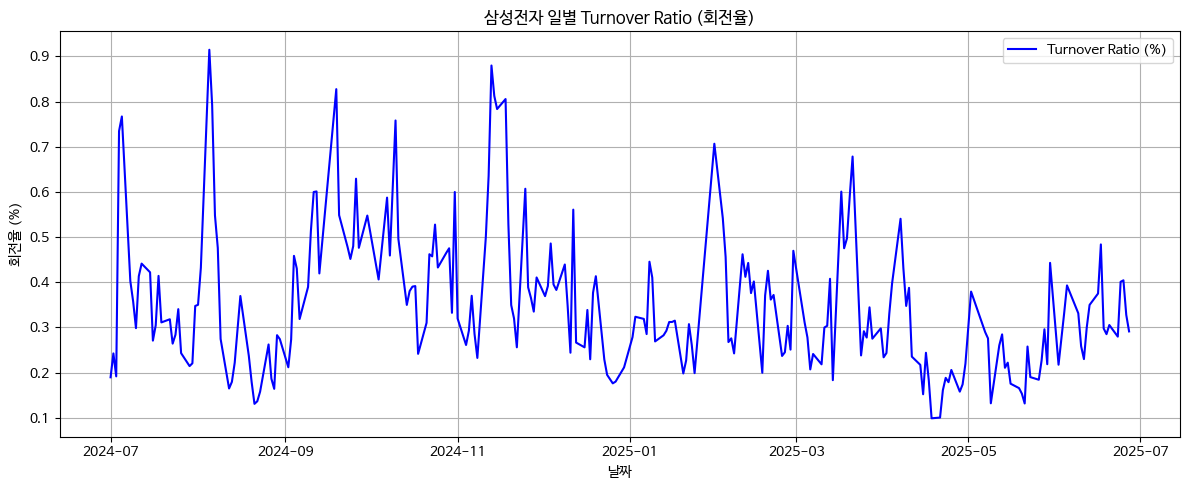

In [34]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 설정: 종목코드 및 기간
ticker = "005930"  # 삼성전자
end = datetime.today()
start = end - timedelta(days=365)  # 최근 1년

# 2. 일별 시세 데이터 불러오기
df_price = stock.get_market_ohlcv_by_date(
    start.strftime('%Y%m%d'),
    end.strftime('%Y%m%d'),
    ticker,
    "d"
)

# 3. 상장주식수 데이터 불러오기
df_cap = stock.get_market_cap_by_date(
    start.strftime('%Y%m%d'),
    end.strftime('%Y%m%d'),
    ticker
)

# 4. 회전율 계산: 거래량 / 상장주식수 × 100 (%)
df = df_price.merge(df_cap[['상장주식수']], left_index=True, right_index=True)
df['turnover'] = (df['거래량'] / df['상장주식수']) * 100  # % 단위

# 5. 결과 출력 (마지막 5일)
print(df[['거래량', '상장주식수', 'turnover']].tail())

# 6. 시각화
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['turnover'], label='Turnover Ratio (%)', color='blue')
plt.title("삼성전자 일별 Turnover Ratio (회전율)")
plt.ylabel("회전율 (%)")
plt.xlabel("날짜")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
